EE21S061 Arihant Jain Lab 9 for EE5175 course:

In [1]:
from PIL import Image
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2

plt.rcParams['figure.figsize'] = [18, 7] 

ModuleNotFoundError: No module named 'cv2'

# Q1. Global threshold value of the given images palmleaf1.pgm and palmleaf2.pgm using Otsu’s thresholding algorithm

Loading in the image and visualizing the images to get a idea of what we are working with.

In [4]:
palmleaf1=cv2.imread("palmleaf1.png",0)
palmleaf2=cv2.imread("palmleaf2.png",0)

Text(0.5, 1.0, 'palmleaf2')

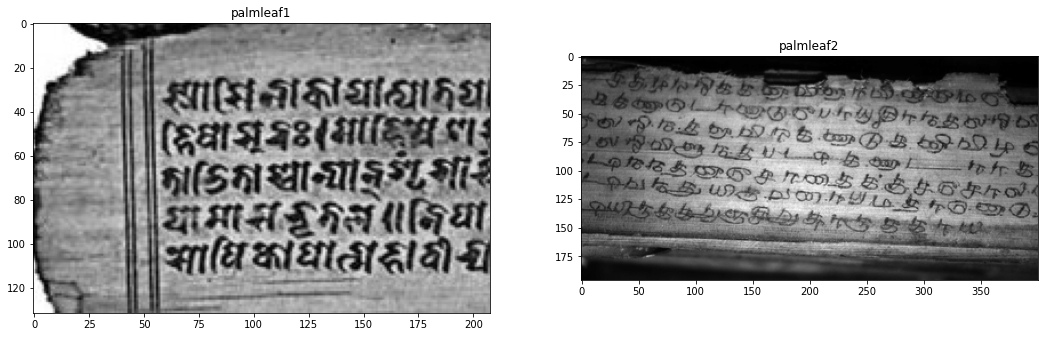

In [5]:
figure, axis = plt.subplots(1, 2)
axis[0].imshow(palmleaf1,cmap="gray")
axis[0].set_title('palmleaf1')
axis[1].imshow(palmleaf2,cmap="gray")
axis[1].set_title('palmleaf2')

We can see how there is a distinction between the letters and the background. This is a good image to perform thresholding.

In [6]:
palmleaf1.shape

(132, 208)

## Plotting the histogram

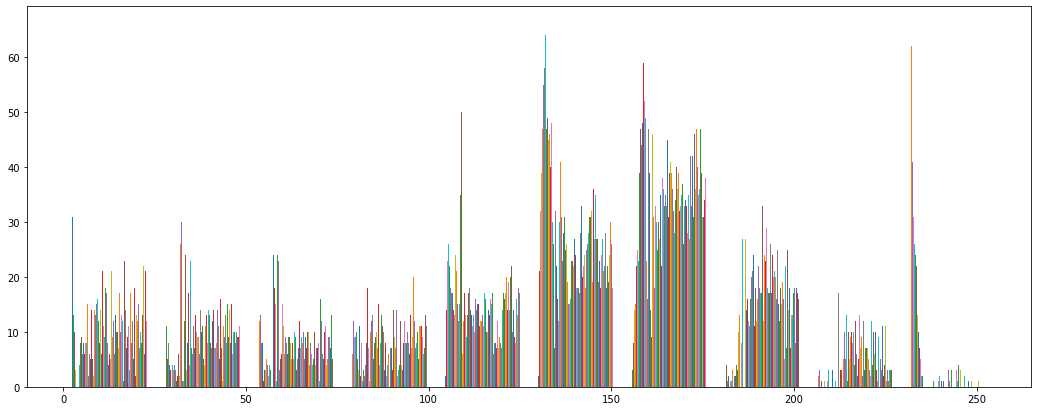

In [7]:
plt.hist(palmleaf1)
plt.show()

# 1.1 Otsu Thresholding:

In the simple case we will be looking for 2 classes in the given histogram.

* Lets assume for a threshold we have t. We 

$$ \sigma_b^2(t) = \sum_{j=1}^{2} (\mu_j (t)- \mu_T)^2 \frac{N_j}{N}  $$

This defines between class variation. The idea is to iterate over t from (0,255) and the 't' for which this maximizes is to be the threshold.


In [9]:
def otsu(image,threshold):
    t=threshold
    total_pixels=image.size
    prob_1=np.sum(image<t)/total_pixels
    prob_2=np.sum(image>=t)/total_pixels
    # calculating mean for each class 
    mean_1=np.sum([i*(np.sum(image==i))/np.sum(image<t) for i in range(t)])
    mean_2=np.sum([i*(np.sum(image==i))/np.sum(image>=t) for i in range(t,255)])
    mean_total=np.sum([i*(np.sum(image==i))/total_pixels for i in range(0,255)])
    # Computiing variance of each class and computing the between class variance from it
    sigma_1=((mean_1-mean_total)**2)*prob_1
    sigma_2=((mean_2-mean_total)**2)*prob_2
    bet_class_var=sigma_1+sigma_2
    # For a t and a image it gives the between class variance for the given t.
    return bet_class_var,t

def otsu_iter(image):
    # This function iterate over the previous function to go from 0 to 255 intensity and look for the t with maximum 
    # between class variance.
    threshold=0
    class_var=0
    for i in range(255):
        var,t=otsu(image,i)
        if class_var<var:
            class_var=var
            threshold=t
    return threshold


103


Text(0.5, 1.0, 'palmleaf1 original ')

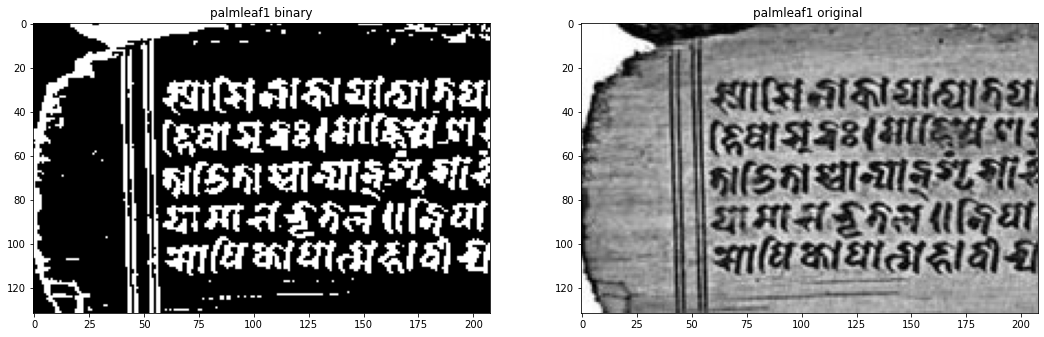

In [10]:
image=palmleaf1
threshold=otsu_iter(image)
print(threshold)
binary_mask = image < threshold
figure, axis = plt.subplots(1, 2)
axis[0].imshow(binary_mask,cmap="gray")
axis[0].set_title('palmleaf1 binary')
axis[1].imshow(image,cmap="gray")
axis[1].set_title('palmleaf1 original ')

* We can see otsu thresholding performed really well for this given image the font and background have a good separation at given intensity of 103. This allows us to for specific feature in the given image.

C:\Users\ariha\AppData\Local\Temp\ipykernel_16640\2642106347.py:8: RuntimeWarning: invalid value encountered in long_scalars
  mean_2=np.sum([i*(np.sum(image==i))/np.sum(image>=t) for i in range(t,255)])


51


Text(0.5, 1.0, 'palmleaf2 original ')

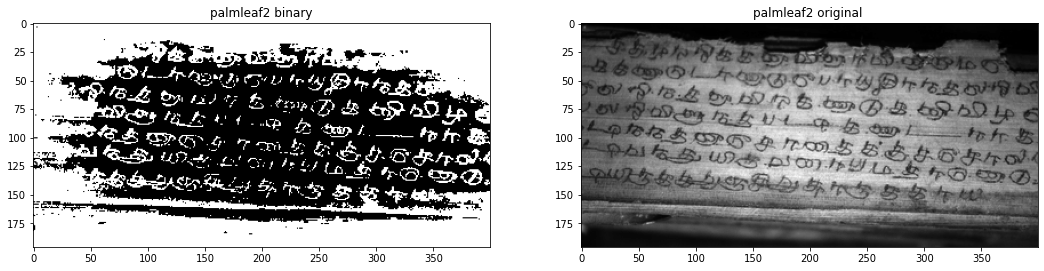

In [11]:
image=palmleaf2
threshold=otsu_iter(image)
print(threshold)
binary_mask = image < threshold
figure, axis = plt.subplots(1, 2)
axis[0].imshow(binary_mask,cmap="gray")
axis[0].set_title('palmleaf2 binary')
axis[1].imshow(image,cmap="gray")
axis[1].set_title('palmleaf2 original ')

* For this image we see that otsu was not able to get a good threshold. This is because we are trying to look for a global threshold which would not work in image like this because the illumination of center is more than its edges this creates issue for global thresholding.

* We can try a local thresholding method to get a better result for this image.

In [114]:
palmleaf1.shape

(132, 208)

# Q2. K- mean Clustering.

In [2]:
car=cv2.cvtColor(cv2.imread("car.jpg"), cv2.COLOR_BGR2RGB)
flower=cv2.cvtColor(cv2.imread("flower.png"), cv2.COLOR_BGR2RGB)

NameError: name 'cv2' is not defined

NameError: name 'car' is not defined

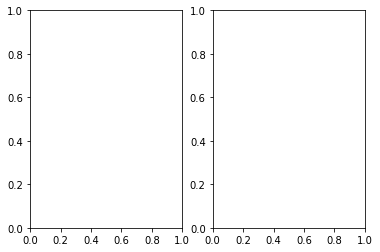

In [3]:
figure, axis = plt.subplots(1, 2)
axis[0].imshow(car)
axis[0].set_title('car')
axis[1].imshow(flower)
axis[1].set_title('flower original ')

The above given image are RGB that means each pixel can be represented as a vector of 3 element $[r,g,b]$. 

We can create clusters around these pixel value. Given cluster are:

# 2.1 Perform K-means clustering with intial cluster.

* For k- Means Clustering the first step is to pick a centroid and assign the given samples into these clusters.

Given clusters:
$$ c_1 = [255,0,0] , c_2 = [0,0,0] , c_3 = [255,255,255]$$

we can compute distance between each centroid and given pixel i as:

$$ dist = {\lVert{ ({\underline x}-{\underline c_1})} \rVert }^2 $$

for each pixel which ever centroid has the minimum distance we assign the sample to that centroid


* Average over the samples in the cluster to get a new centroid and we can iterate this over to get a better estimate of where the centroid for these images are.

In [86]:
def k_means(image,k,iteration,each_iter_error=False):
    clusters_centroid=[]
    if(k==0):
        # Setting up the centroid mentioned in the question.
        clusters_centroid.append(np.array([255,0,0]))
        clusters_centroid.append(np.array([0,0,0]))
        clusters_centroid.append(np.array([255,255,255]))
    else:
        # intializing k random centroid 
        for i in range(k):
            clusters_centroid.append(np.random.rand(1,3)*255)
    clusters={}
    image_cluster=np.zeros_like((image))
    # empty numpy array to hold image with each centroid to visualize the clusters.
    costs=[]
    for it in range(iteration):
        clusters={}
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                dist=[]
                for k in range(len(clusters_centroid)):
                    # Computing Distance to every centroid
                    dist.append(np.linalg.norm(clusters_centroid[k]-image[i,j,:]))
                index=dist.index(min(dist))
                image_cluster[i][j][:]=clusters_centroid[index]
                if index in clusters.keys():
                    # Assigning pixel to cluster with minimum distance/
                    clusters[index].append(image[i,j,:])
                else:
                    clusters[index]=[]
                    clusters[index].append(image[i,j,:])
        for i in clusters.keys():
            # Computing centroid for next iteration of k-means
            clusters_centroid[i]=np.sum(clusters[i],axis=0)/len(clusters[i])
        cost=0
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                cost+=(np.linalg.norm(image_cluster[i,j,:]-image[i,j,:]))
        costs.append(cost)
    if each_iter_error==True:
        return image_cluster,clusters_centroid,costs
    return image_cluster,clusters_centroid,costs[:-1]

In [87]:
image=car

In [88]:
img_1,centroid_1,cost_1=k_means(image,0,1)

In [89]:
img_2,centroid_2,cost_2=k_means(image,0,2)

In [90]:
img_10,centroid_10,cost_10=k_means(image,0,10)

Text(0.5, 1.0, 'Original')

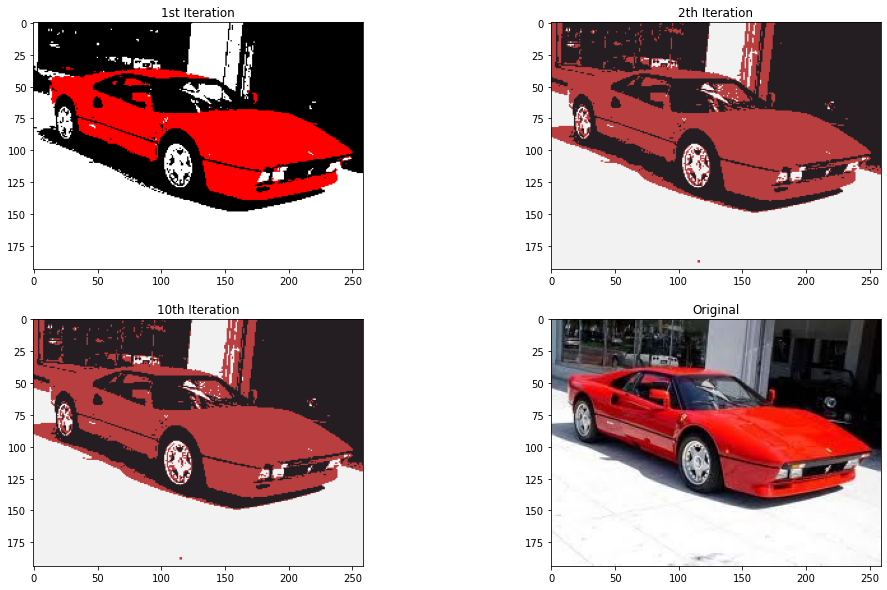

In [91]:
plt.rcParams['figure.figsize'] = [17, 10] 
figure, axis = plt.subplots(2, 2)
axis[0][0].imshow(img_1)
axis[0][0].set_title('1st Iteration')
axis[0][1].imshow(img_2)
axis[0][1].set_title('2th Iteration')
axis[1][0].imshow(img_10)
axis[1][0].set_title('10th Iteration')
axis[1][1].imshow(image)
axis[1][1].set_title('Original')

* We can see how k-means cluster are segmenting the different object in the image like car, building and the background.
* In 1 iteration we move a little from the centroid intially given and thus the algorithm is trying to find the closest centroid from the given centroid.
* In the 2 iteration we can see significant improvement. we can apply a stop condition to stop iteration if the cluster formed are really well and do not adjust once formed.
* At 10th iteration we have averaged the centroid over many iteration these centroid defines the image object very well this is visible from the comparision between the original and the 10 iteration image.

In [67]:
centroid_1

[array([209.5452647 ,  40.12070586,  37.32515401]),
 array([43.88424025, 37.74702259, 42.80723819]),
 array([234.75043655, 234.8923498 , 236.67827646])]

In [68]:
centroid_10

[array([183.2905819 ,  62.93185338,  64.06504904]),
 array([35.4669383 , 29.21164144, 33.54476135]),
 array([243.05367304, 243.06828318, 244.08504639])]

In [69]:
image=flower

In [70]:
img_1,centroid_1,cost_1=k_means(image,0,1)

In [76]:
img_2,centroid_2,cost_2=k_means(image,0,10)

In [72]:
img_10,centroid_10,cost_10=k_means(image,0,10)

Text(0.5, 1.0, 'Original')

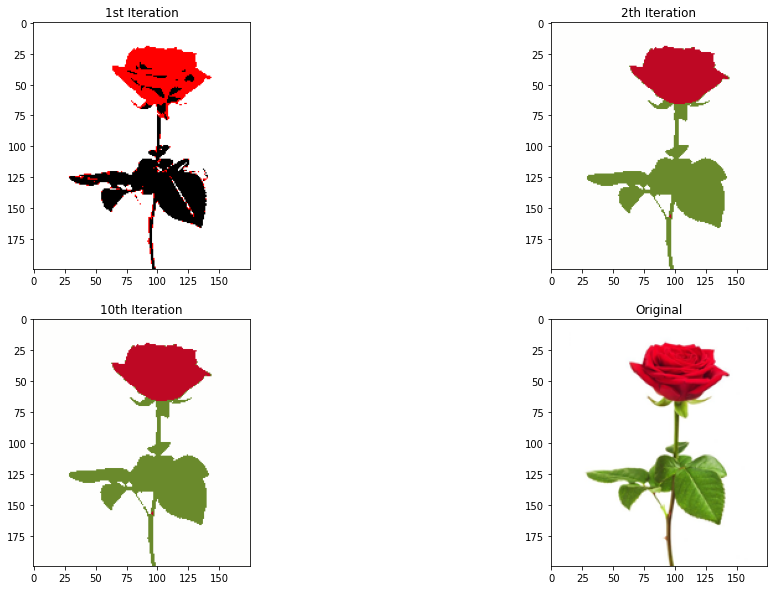

In [77]:
plt.rcParams['figure.figsize'] = [17, 10] 
figure, axis = plt.subplots(2, 2)
axis[0][0].imshow(img_1)
axis[0][0].set_title('1st Iteration')
axis[0][1].imshow(img_2)
axis[0][1].set_title('2th Iteration')
axis[1][0].imshow(img_10)
axis[1][0].set_title('10th Iteration')
axis[1][1].imshow(image)
axis[1][1].set_title('Original')

## Similar observation in the second image.

* We can see how k-means cluster are segmenting the different object in the image like leafs, flower and the background.
* In 1 iteration we move a little from the centroid intially given and thus the algorithm is trying to find the closest centroid from the given centroid. In this image its more prominent as the the intial cluster specify a [0,0,0] which is not a color being used for this image thus that cluster is really far and hence create issue for the leaf in the image but still the segment are really well and this issue resolves itself by 2nd iteration.

In [53]:
centroid_1

[array([191.84297855,  28.71428571,  41.8976123 ]),
 array([ 93.33966245, 119.66606389,  30.85443038]),
 array([252.77463969, 253.08240047, 251.09403992])]

In [54]:
centroid_10

[array([190.02312868,   8.63540791,  36.7275021 ]),
 array([106.3683274 , 138.43340112,  44.3378241 ]),
 array([254.36478667, 254.31061768, 253.72451896])]

## 2.2 Random intialize the cluster and look for error.

Generally we do not know what are the cluster we should intialize the k-means algorithm this is taken care by either looking for cluster manually in the image as we did in last example for we can random intialize a cluster centroid and see how good our guess was.

To compare between different choice of centroid we can look for error which in this case would be:

$$ cost = \sum_{i=1}^{P}  {\lVert{ ({\underline {x_i}}-{\underline {c_i}})} \rVert }^2 $$

for each pixel in the image computing its distance to the centroid its assigned to.

The idea is to minimize the cost which would translate to a centroid which has minimum mean distance to each pixel.

In [83]:
error=[]
image=flower
for i in range(1,30):
    img,centroid,cost=k_means(image,3,1)
    error.append(cost)


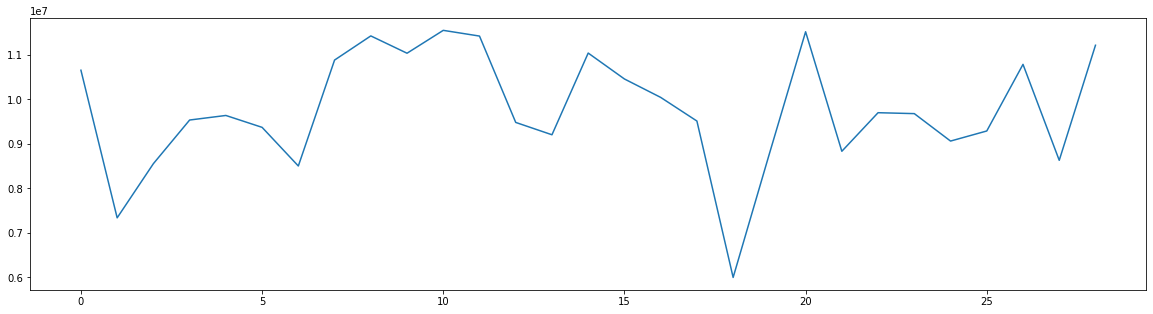

In [95]:
plt.rcParams['figure.figsize'] = [20,5] 
plt.plot(range(29),error)

* The above code runs k-means clustering method to compute cost for 1st iteration over 30 random initalization of centroid.

* The above plot is error we get by randomly selecting a centroid this varies randomly as each iteration is a random sampling.

In [111]:
img,centroid,cost=k_means(image,3,30,True)

* We can iterate the k-means algorithm to average the centroid every iteration and see how the error evolves over time this ideally should minimize and find a local minima in the search space

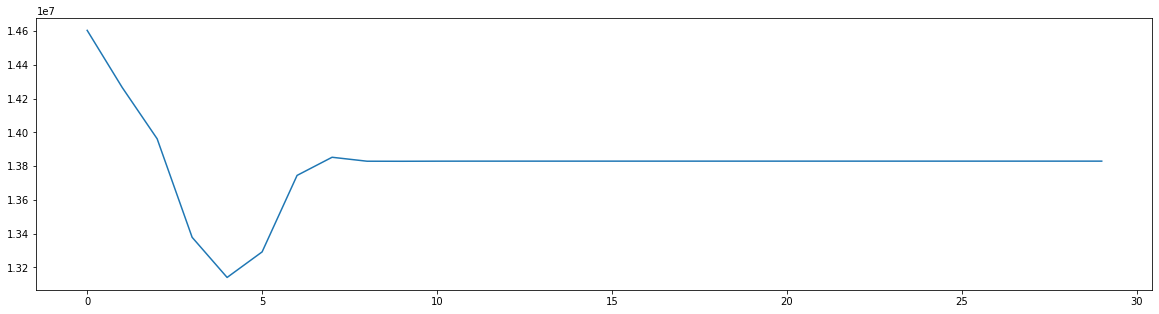

In [112]:
plt.rcParams['figure.figsize'] = [20,5] 
plt.plot(range(len(cost)),cost)

* We can see how error is now following a pattern in this case its trying to actively minimize the cost it gets each iteration hence the amplitude of the graph looks like dying off as the graph stablizes with a local minima for given centroids.

Text(0.5, 1.0, 'Original')

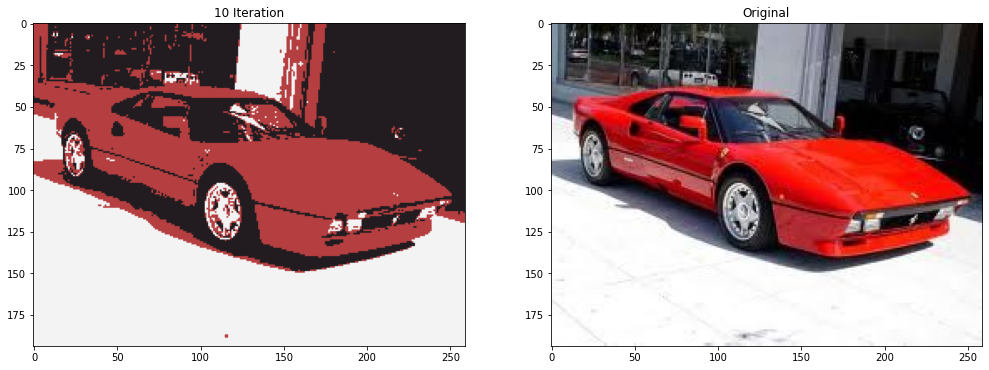

In [113]:
plt.rcParams['figure.figsize'] = [17, 10] 
figure, axis = plt.subplots(1, 2)
axis[0].imshow(img)
axis[0].set_title('10 Iteration')
axis[1].imshow(image)
axis[1].set_title('Original')